In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

from transformers import ViTForImageClassification, ViTImageProcessor

Загрузим обученную модель

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
model_path = '../saved_model'

processor = ViTImageProcessor.from_pretrained(
    pretrained_model_name_or_path=model_path
)
model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path=model_path,
    attn_implementation="eager",
    output_attentions=True
).to(device)
model.eval()


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

Загрузим датасеты

In [17]:
def denormalize_vit(image_tensor: torch.Tensor) -> torch.Tensor:
    """
    Выполняет обратное преобразование для изображения,
    обработанного с помощью ViTImageProcessor с параметрами:
        - do_rescale=True, rescale_factor=0.00392156862745098
        - do_normalize=True, image_mean=[0.5, 0.5, 0.5], image_std=[0.5, 0.5, 0.5]
    
    Параметры:
      image_tensor (torch.Tensor): тензор изображения в формате (C, H, W)
                                    с нормализованными значениями в диапазоне [-1, 1].
    
    Возвращает:
      torch.Tensor: денормализованное изображение с пиксельными значениями от 0 до 255.
    """
    if isinstance(image_tensor, np.ndarray):
        image_tensor = torch.tensor(image_tensor)
    # Обратное преобразование нормализации: (x * std + mean)
    # В нашем случае: image_rescaled = image_tensor * 0.5 + 0.5,
    # что возвращает значения в диапазоне [0, 1]
    image_rescaled = image_tensor * 0.5 + 0.5
    
    # Обратное преобразование рескейла: делим на rescale_factor (то же, что умножить на 255)
    rescale_factor = 1/255
    image_denorm = image_rescaled / rescale_factor
    
    image_denorm = image_denorm.clamp(0, 255).to(torch.uint8)
    
    return image_denorm

In [25]:
import sys
import os

project_root = 'D:\\pythonProjects\\AIRetailVision\\src'
sys.path.append(project_root)

from custom_dataset import CustomDataset
import json

with open('../src/config.json', 'r') as f:
    config = json.load(f)

test_dataset = CustomDataset(
    root_dir=config['testing_data']['path_orig_test'],
    processor=processor
)

adversarial_test_dataset = CustomDataset(
    root_dir=config['testing_data']['path_pgd_test'],
    processor=processor
)

Выберем номер анализируемого изображения и прогоним его через модель

In [93]:
num_image = 119

In [104]:
orig_image_tensor = adversarial_test_dataset[num_image]['pixel_values'].to(device)
output = model(orig_image_tensor.unsqueeze(0))
attentions = output.attentions

In [113]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

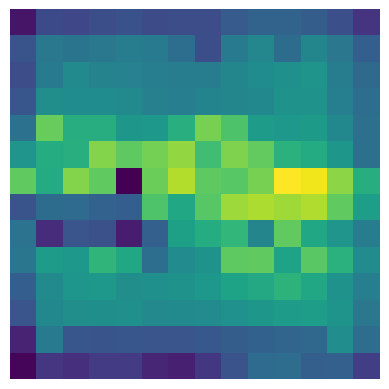

In [114]:
rollout = attention_rollout(attentions)
num_of_patches = 196
cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))
plt.axis(False)
plt.imshow(cls_attention.detach().cpu())

In [115]:
import numpy as np
from PIL import Image, ImageFilter

# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# Convert to numpy, multiply by 255, and cast to uint8
cls_attention_np = (cls_attention.detach().cpu().numpy() * 255).astype(np.uint8)
img_size = 224
# Resize and blur the attention map
cls_attention_resized = Image.fromarray(cls_attention_np).resize((img_size, img_size), resample=Image.BICUBIC)
cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))


(-0.5, 223.5, 223.5, -0.5)

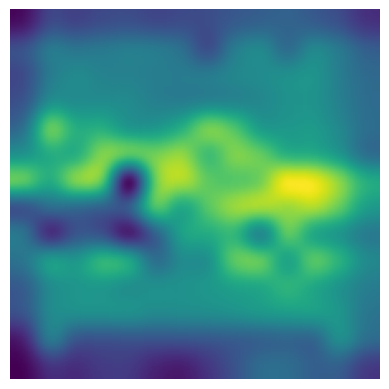

In [122]:
plt.imshow(cls_attention_resized)
plt.axis('off')

In [117]:
# Convert the attention map to RGBA
cls_attention_colored = np.array(cls_attention_resized.convert("L"))
cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)

# Adjust the alpha channel to control brightness
cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
cls_attention_colored_img.putalpha(200)  # Adjust alpha for blending (lower value for darker overlay)

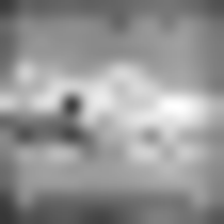

In [118]:
cls_attention_colored_img

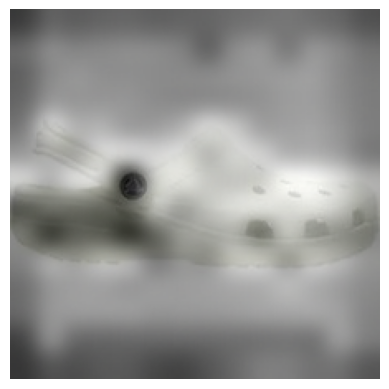

In [121]:
image = denormalize_vit(orig_image_tensor).cpu().numpy().transpose(1, 2, 0)
pil_image = Image.fromarray(image).convert('RGBA')

blended_img = Image.alpha_composite(pil_image, cls_attention_colored_img)

plt.imshow(blended_img)
plt.axis('off')
plt.show()

Объединим всё в одну функцию

In [136]:
def rollout_attention_on_image(num_image):
    orig_image_tensor = test_dataset[num_image]['pixel_values'].to(device)
    adv_image_tensor = adversarial_test_dataset[num_image]['pixel_values'].to(device)
    orig_output = model(orig_image_tensor.unsqueeze(0))
    adv_output = model(adv_image_tensor.unsqueeze(0))
    orig_attentions = orig_output.attentions
    adv_attentions = adv_output.attentions
    orig_rollout = attention_rollout(orig_attentions)
    adv_rollout = attention_rollout(adv_attentions)
    num_of_patches = 196
    
    def get_cls_attention_colored_img(rollout):
        rollout = attention_rollout(attentions)
        num_of_patches = 196
        cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
        cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))
        # Normalize the attention map for better visualization
        cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())
        
        # Convert to numpy, multiply by 255, and cast to uint8
        cls_attention_np = (cls_attention.detach().cpu().numpy() * 255).astype(np.uint8)
        img_size = 224
        # Resize and blur the attention map
        cls_attention_resized = Image.fromarray(cls_attention_np).resize((img_size, img_size), resample=Image.BICUBIC)
        cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))
        # Convert the attention map to RGBA
        cls_attention_colored = np.array(cls_attention_resized.convert("L"))
        cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)
        
        # Adjust the alpha channel to control brightness
        cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
        cls_attention_colored_img.putalpha(200)  # Adjust alpha for blending (lower value for darker overlay)
        return cls_attention_colored_img
        
    orig_cls_attention_colored_img = get_cls_attention_colored_img(orig_rollout)
    adv_cls_attention_colored_img = get_cls_attention_colored_img(adv_rollout)

    orig_image = denormalize_vit(orig_image_tensor).cpu().numpy().transpose(1, 2, 0)
    adv_image = denormalize_vit(adv_image_tensor).cpu().numpy().transpose(1, 2, 0)
    pil_orig_image = Image.fromarray(orig_image).convert('RGBA')
    pil_adv_image = Image.fromarray(adv_image).convert('RGBA')
    
    blended_orig_img = Image.alpha_composite(pil_orig_image, orig_cls_attention_colored_img)
    blended_adv_img = Image.alpha_composite(pil_adv_image, adv_cls_attention_colored_img)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(blended_orig_img)
    axes[0].set_title("Оригинальное изображение")
    axes[0].axis("off")
    
    axes[1].imshow(blended_adv_img)
    axes[1].set_title("Атакованное изображение")
    axes[1].axis("off")
    
    plt.show()
   

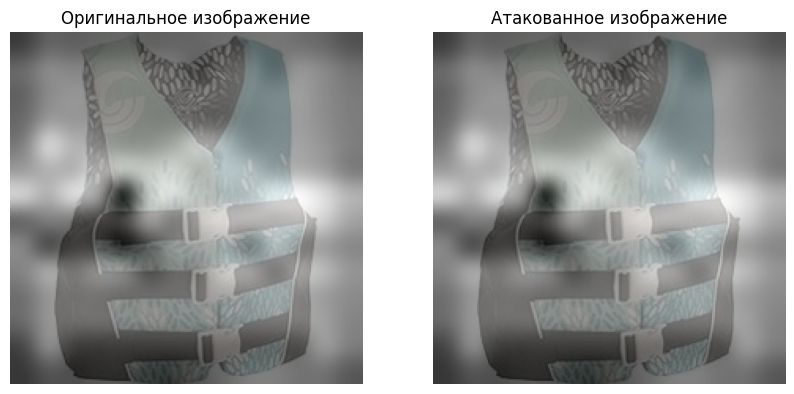

In [144]:
rollout_attention_on_image(num_image=500)